
# Algoritmi di **Ricerca Informata** (Greedy, A\*, Weighted A\*, IDA\*, RBFS, Beam)

Obiettivo: capire e provare sul campo gli algoritmi di ricerca **guidati da euristica**.

**Contenuti**
- Definizioni: `f(n) = g(n) + h(n)`, ammissibilità, consistenza
- Implementazioni pulite e misurabili di:
  - **Greedy Best‑First** (minimizza `h`)
  - **A\*** (minimizza `f = g + h`)
  - **Weighted A\*** (`f_w = g + w*h`)
  - **IDA\*** (Iterative Deepening A\*)
  - **RBFS** (Recursive Best‑First Search)
  - **Beam Search** (euristica, memoria limitata)
- Esempi su **griglia 4‑connessa** con ostacoli, costi uniformi e variabili
- Verifica di **consistenza** per l'euristica Manhattan



## Osservazioni pratiche
- **A\***: con `h` ammissibile & consistente → soluzione **ottima**. In *B* espande meno di UCS (non incluso qui) grazie a `h`.
- **Greedy**: spesso veloce, ma ignora `g` → rischia percorsi in aree con **alti costi**.
- **Weighted A\***: tuning di `w` (1.2–2.0 tipicamente) riduce espansioni sacrificando un po' di ottimalità.
- **IDA\***: memoria bassa, tempo maggiore; buono per spazi con **profondità alta** e **branching moderato**.
- **RBFS**: simile ad A* ma **memory‑bounded**; meno overhead di IDA* in alcuni scenari.
- **Beam**: utile quando la memoria è rigidamente limitata; non garantisce completezza/ottimalità.



## Setup


In [4]:
import os; os.environ.setdefault("MPLBACKEND","Agg")

from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Callable, Iterable, Set
import heapq
import math
import time

import matplotlib.pyplot as plt

Coord = Tuple[int,int]

@dataclass
class SearchResult:
    path: List[Coord]
    cost: float
    expanded: int
    max_frontier: int
    found: bool
    name: str
    runtime_s: float



## Ambiente: griglia 4‑connessa con ostacoli
`step_cost` può dipendere dalla cella di arrivo (per simulare pesi).


In [5]:
class Grid:
    def __init__(self, rows: int, cols: int, walls: Set[Coord] | None = None, cost_fn: Optional[Callable[[Coord], float]] = None):
        self.rows, self.cols = rows, cols
        self.walls = walls or set()
        self.cost_fn = cost_fn or (lambda _: 1.0)

    def in_bounds(self, s: Coord) -> bool:
        r, c = s
        return 0 <= r < self.rows and 0 <= c < self.cols

    def passable(self, s: Coord) -> bool:
        return s not in self.walls

    def neighbors(self, s: Coord) -> Iterable[Coord]:
        r, c = s
        for dr, dc in [(-1,0),(0,1),(1,0),(0,-1)]:
            t = (r+dr, c+dc)
            if self.in_bounds(t) and self.passable(t):
                yield t

    def step_cost(self, s: Coord, t: Coord) -> float:
        return float(self.cost_fn(t))

def reconstruct_path(came_from: Dict[Coord, Optional[Coord]], start: Coord, goal: Coord) -> List[Coord]:
    if goal not in came_from:
        return []
    cur = goal
    out = [cur]
    while cur != start:
        cur = came_from[cur]
        if cur is None:
            return []
        out.append(cur)
    out.reverse()
    return out

def manhattan(a: Coord, b: Coord) -> float:
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def plot_grid(grid: Grid, start: Coord, goal: Coord, path: List[Coord] | None = None, title: str = ""):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(-0.5, grid.cols-0.5)
    ax.set_ylim(-0.5, grid.rows-0.5)
    ax.set_xticks(range(grid.cols))
    ax.set_yticks(range(grid.rows))
    ax.grid(True)

    for (r,c) in grid.walls:
        ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, alpha=0.5))

    if path:
        xs = [c for r,c in path]
        ys = [r for r,c in path]
        ax.plot(xs, ys, linewidth=2, marker="o")

    ax.text(start[1], start[0], "S", ha="center", va="center", fontsize=12)
    ax.text(goal[1], goal[0], "G", ha="center", va="center", fontsize=12)
    ax.set_title(title)
    plt.show()



## Algoritmi di ricerca informata
### 1) Greedy Best‑First (minimizza `h`)


In [6]:

def greedy_best_first(grid: Grid, start: Coord, goal: Coord, h: Callable[[Coord], float]) -> SearchResult:
    t0 = time.perf_counter()
    frontier: List[Tuple[float, Coord]] = [(h(start), start)]
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    visited: Set[Coord] = set()
    expanded = 0
    max_frontier = 1

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        _, s = heapq.heappop(frontier)
        if s in visited:
            continue
        visited.add(s)
        expanded += 1
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            t1 = time.perf_counter()
            return SearchResult(path, cost=len(path)-1 if path else math.inf, expanded=expanded,
                                max_frontier=max_frontier, found=bool(path), name="Greedy", runtime_s=t1-t0)
        for t in grid.neighbors(s):
            if t not in visited:
                if t not in came_from:  # registra primo padre (non ottimo garantito)
                    came_from[t] = s
                heapq.heappush(frontier, (h(t), t))

    t1 = time.perf_counter()
    return SearchResult([], math.inf, expanded, max_frontier, False, "Greedy", t1-t0)



### 2) A\* (minimizza `f = g + h`)
Con `h` **ammissibile e consistente** → **ottimo** e **completo** (costi non negativi).


In [7]:

def astar(grid: Grid, start: Coord, goal: Coord, h: Callable[[Coord], float]) -> SearchResult:
    t0 = time.perf_counter()
    frontier: List[Tuple[float, Coord]] = [(0.0, start)]  # (f, stato)
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    g: Dict[Coord, float] = {start: 0.0}
    expanded = 0
    max_frontier = 1

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        f_s, s = heapq.heappop(frontier)
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            t1 = time.perf_counter()
            return SearchResult(path, cost=g[s], expanded=expanded, max_frontier=max_frontier,
                                found=True, name="A*", runtime_s=t1-t0)
        expanded += 1
        for t in grid.neighbors(s):
            new_g = g[s] + grid.step_cost(s, t)
            if t not in g or new_g < g[t]:
                g[t] = new_g
                came_from[t] = s
                heapq.heappush(frontier, (new_g + h(t), t))

    t1 = time.perf_counter()
    return SearchResult([], math.inf, expanded, max_frontier, False, "A*", t1-t0)



### 3) Weighted A\* (WA\*) — `f_w = g + w*h`
- Con `w > 1` diventa **più aggressivo** (spesso meno espansioni) ma **può perdere ottimalità**.
- Se `h` è ammissibile, WA\* con `w` vicino a 1 fornisce soluzioni quasi ottime spesso più rapide.


In [8]:

def weighted_astar(grid: Grid, start: Coord, goal: Coord, h: Callable[[Coord], float], w: float=1.5) -> SearchResult:
    assert w >= 1.0
    t0 = time.perf_counter()
    frontier: List[Tuple[float, Coord]] = [(0.0, start)]  # (f_w, stato)
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    g: Dict[Coord, float] = {start: 0.0}
    expanded = 0
    max_frontier = 1

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        f_s, s = heapq.heappop(frontier)
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            t1 = time.perf_counter()
            return SearchResult(path, cost=g[s], expanded=expanded, max_frontier=max_frontier,
                                found=True, name=f"WA*(w={w})", runtime_s=t1-t0)
        expanded += 1
        for t in grid.neighbors(s):
            new_g = g[s] + grid.step_cost(s, t)
            if t not in g or new_g < g[t]:
                g[t] = new_g
                came_from[t] = s
                f_w = new_g + w * h(t)
                heapq.heappush(frontier, (f_w, t))

    t1 = time.perf_counter()
    return SearchResult([], math.inf, expanded, max_frontier, False, f"WA*(w={w})", t1-t0)



### 4) IDA\* — Iterative Deepening A\*
Profondità su **soglia `f`** crescenti. Memoria O(b·d). Ottimo con `h` ammissibile & consistente.


In [6]:

def ida_star(grid: Grid, start: Coord, goal: Coord, h: Callable[[Coord], float]) -> SearchResult:
    t0 = time.perf_counter()

    def search(path: List[Coord], g: float, bound: float) -> Tuple[float, Optional[List[Coord]], int]:
        s = path[-1]
        f = g + h(s)
        if f > bound:
            return f, None, 0
        if s == goal:
            return f, path[:], 0
        min_bound = math.inf
        expanded_here = 0
        for t in grid.neighbors(s):
            if t in path:
                continue  # evita cicli sul path corrente
            expanded_here += 1
            t_cost = g + grid.step_cost(s, t)
            path.append(t)
            t_bound, result_path, exp_child = search(path, t_cost, bound)
            expanded_here += exp_child
            if result_path is not None:
                return t_bound, result_path, expanded_here
            if t_bound < min_bound:
                min_bound = t_bound
            path.pop()
        return min_bound, None, expanded_here

    bound = h(start)
    total_expanded = 0
    while True:
        new_bound, result_path, expanded = search([start], 0.0, bound)
        total_expanded += expanded
        if result_path is not None:
            t1 = time.perf_counter()
            return SearchResult(result_path, cost=len(result_path)-1, expanded=total_expanded,
                                max_frontier=0, found=True, name="IDA*", runtime_s=t1-t0)
        if new_bound == math.inf:
            t1 = time.perf_counter()
            return SearchResult([], math.inf, total_expanded, 0, False, "IDA*", t1-t0)
        bound = new_bound



### 5) RBFS — Recursive Best‑First Search
Mantiene un limite `f_limit` ricorsivo e torna indietro quando supera il limite, ricordando la **migliore alternativa**.


In [7]:

def rbfs(grid: Grid, start: Coord, goal: Coord, h: Callable[[Coord], float]) -> SearchResult:
    t0 = time.perf_counter()

    def recurse(s: Coord, g: float, f_limit: float, came_from: Dict[Coord, Coord]) -> Tuple[Optional[List[Coord]], float, int, int]:
        expanded_local = 0
        max_frontier_local = 1

        if s == goal:
            return [s], g, expanded_local, max_frontier_local

        successors = []
        for t in grid.neighbors(s):
            f = g + grid.step_cost(s, t) + h(t)
            successors.append([t, g + grid.step_cost(s, t), f])
        if not successors:
            return None, math.inf, expanded_local, max_frontier_local

        while True:
            successors.sort(key=lambda x: x[2])  # ordina per f
            best = successors[0]
            if best[2] > f_limit:
                return None, best[2], expanded_local, max_frontier_local
            alternative = successors[1][2] if len(successors) > 1 else math.inf
            came_from[best[0]] = s
            result, best_f, exp_child, maxf_child = recurse(best[0], best[1], min(f_limit, alternative), came_from)
            expanded_local += 1 + exp_child
            max_frontier_local = max(max_frontier_local, maxf_child)
            best[2] = best_f
            if result is not None:
                return [s] + result, best_f, expanded_local, max_frontier_local

    came_from: Dict[Coord, Coord] = {}
    path, fval, expanded, maxf = recurse(start, 0.0, math.inf, came_from)
    t1 = time.perf_counter()
    if path:
        return SearchResult(path, cost=len(path)-1, expanded=expanded, max_frontier=maxf, found=True, name="RBFS", runtime_s=t1-t0)
    return SearchResult([], math.inf, expanded, maxf, False, "RBFS", t1-t0)



### 6) Beam Search (ampiezza limitata `k`)
Non ottima, non completa in generale; utile quando la memoria è un vincolo rigido.


In [8]:

def beam_search(grid: Grid, start: Coord, goal: Coord, h: Callable[[Coord], float], k: int=3) -> SearchResult:
    t0 = time.perf_counter()
    if start == goal:
        t1 = time.perf_counter()
        return SearchResult([start], 0.0, 0, 1, True, f"Beam(k={k})", t1-t0)

    level: List[Tuple[float, Coord, Optional[Coord]]] = [(h(start), start, None)]  # (h, state, parent)
    parents: Dict[Coord, Optional[Coord]] = {start: None}
    expanded = 0
    max_frontier = len(level)

    while level:
        # espansione del livello corrente
        candidates: List[Tuple[float, Coord, Coord]] = []
        for _, s, _parent in level:
            expanded += 1
            for t in grid.neighbors(s):
                candidates.append((h(t), t, s))

        # pruning: tieni solo i k migliori secondo h
        candidates.sort(key=lambda x: x[0])
        level = []
        seen: Set[Coord] = set()
        for i in range(min(k, len(candidates))):
            hv, t, p = candidates[i]
            if t in seen:
                continue
            seen.add(t)
            parents.setdefault(t, p if t not in parents else parents[t])
            level.append((hv, t, p))
            if t == goal:
                # ricostruzione
                path = [t]
                while path[-1] is not None:
                    p = parents[path[-1]]
                    if p is None:
                        break
                    path.append(p)
                path.reverse()
                t1 = time.perf_counter()
                return SearchResult(path, cost=len(path)-1, expanded=expanded, max_frontier=max_frontier,
                                    found=True, name=f"Beam(k={k})", runtime_s=t1-t0)
        max_frontier = max(max_frontier, len(level))

    t1 = time.perf_counter()
    return SearchResult([], math.inf, expanded, max_frontier, False, f"Beam(k={k})", t1-t0)



## Proprietà dell'euristica: ammissibilità e consistenza
Verifichiamo la **consistenza** di Manhattan (4‑connessa, costo minimo per passo ≥ 1).


In [9]:

def check_consistency(grid: Grid, goal: Coord, h: Callable[[Coord], float]) -> Tuple[bool, int]:
    violations = 0
    for r in range(grid.rows):
        for c in range(grid.cols):
            s = (r,c)
            if not grid.passable(s): 
                continue
            for t in grid.neighbors(s):
                if h(s) > grid.step_cost(s, t) + h(t) + 1e-9:
                    violations += 1
    return violations == 0, violations



## Esperimenti
Useremo una griglia 10×10 con ostacoli, **Scenario A**: costi uniformi; **Scenario B**: costi variabili.


Consistenza Manhattan (A): (True, 0)
Consistenza Manhattan (B): (True, 0)
Greedy       | found=True | cost=18.0 | expanded=19 | maxF=17 | t=0.0001s
A*           | found=True | cost=18.0 | expanded=85 | maxF=10 | t=0.0012s
WA*(w=1.5)   | found=True | cost=18.0 | expanded=18 | maxF=16 | t=0.0002s
IDA*         | found=True | cost=18.0 | expanded=18 | maxF=0 | t=0.0004s
RBFS         | found=True | cost=18.0 | expanded=18 | maxF=1 | t=0.0005s
Beam(k=3)    | found=True | cost=18.0 | expanded=36 | maxF=3 | t=0.0004s


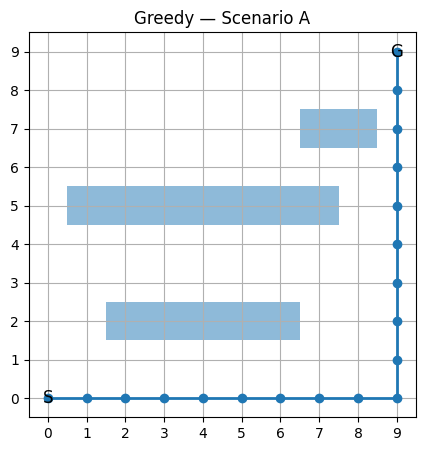

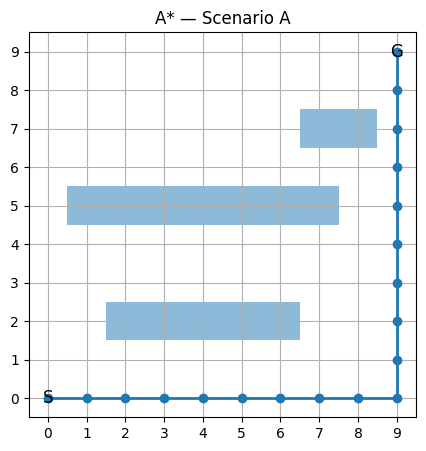

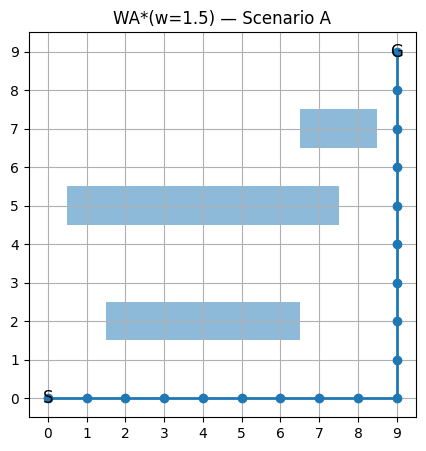

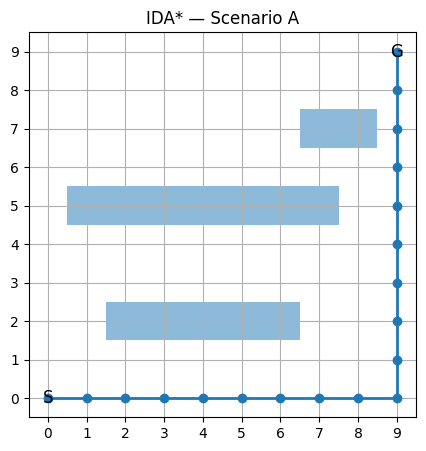

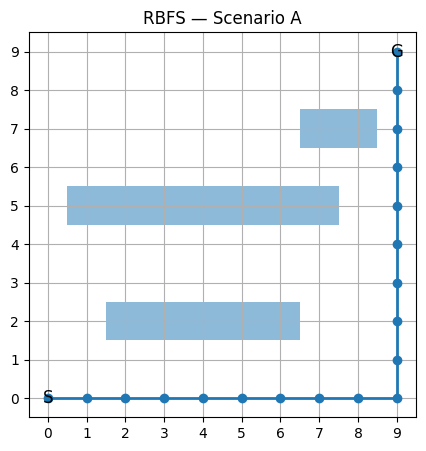

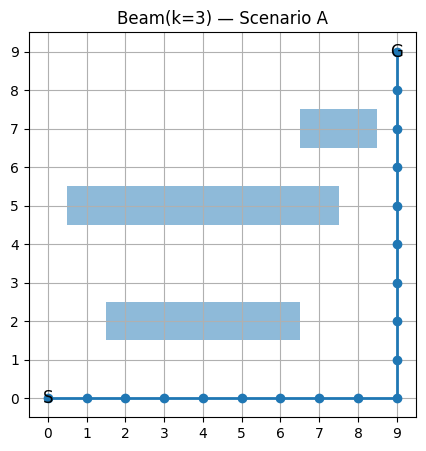

Greedy       | found=True | cost=18.0 | expanded=19 | maxF=17 | t=0.0001s
A*           | found=True | cost=18.0 | expanded=65 | maxF=16 | t=0.0002s
WA*(w=1.5)   | found=True | cost=18.0 | expanded=18 | maxF=16 | t=0.0001s
IDA*         | found=True | cost=18.0 | expanded=18 | maxF=0 | t=0.0001s
RBFS         | found=True | cost=18.0 | expanded=18 | maxF=1 | t=0.0001s
Beam(k=3)    | found=True | cost=18.0 | expanded=36 | maxF=3 | t=0.0001s


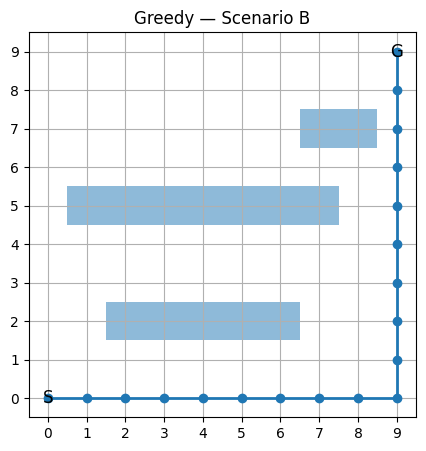

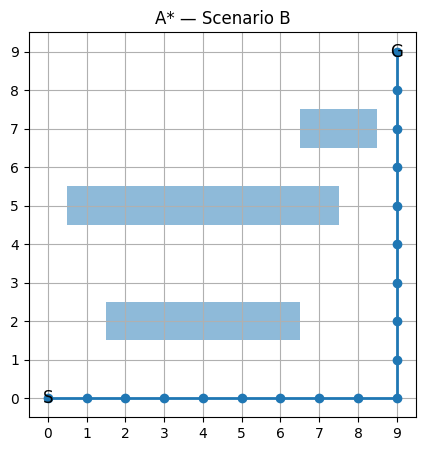

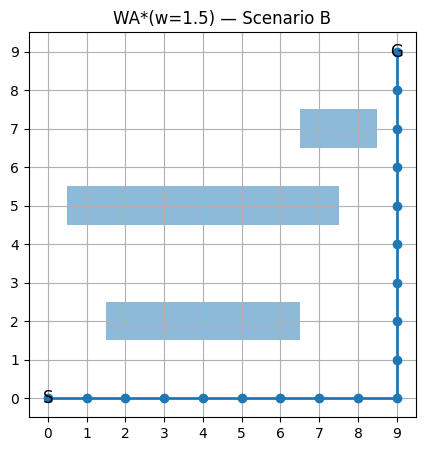

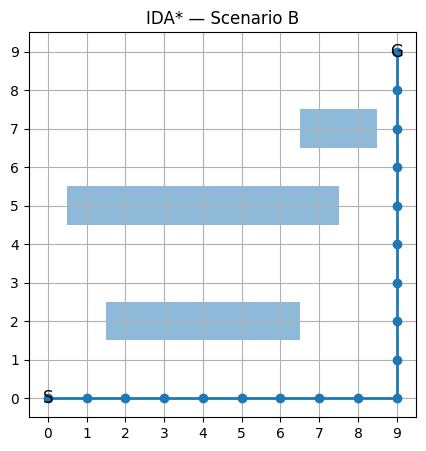

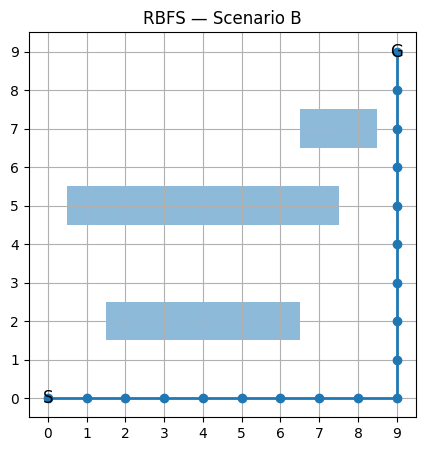

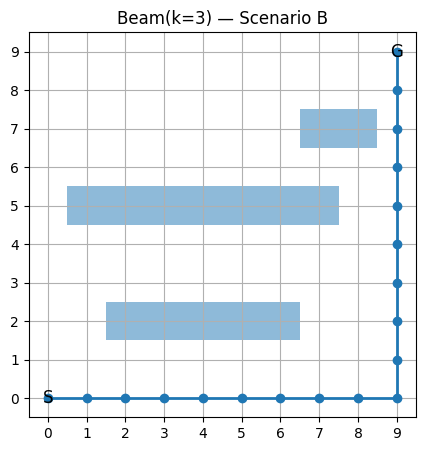

In [10]:

# Definizione ambiente
rows, cols = 10, 10
walls = {
    (2,2),(2,3),(2,4),(2,5),(2,6),
    (5,1),(5,2),(5,3),(5,4),(5,5),(5,6),(5,7),
    (7,7),(7,8)
}
start, goal = (0,0), (9,9)

gridA = Grid(rows, cols, walls=walls)
gridB = Grid(rows, cols, walls=walls, cost_fn=lambda cell: 5.0 if cell in {(3,3),(3,4),(3,5),(4,5),(6,2),(6,3),(6,4),(7,4),(8,4)} else 1.0)

hA = lambda s: manhattan(s, goal)

print("Consistenza Manhattan (A):", check_consistency(gridA, goal, hA))
print("Consistenza Manhattan (B):", check_consistency(gridB, goal, hA))

# Run su Scenario A (costi uniformi)
res = []
res.append(greedy_best_first(gridA, start, goal, hA))
res.append(astar(gridA, start, goal, hA))
res.append(weighted_astar(gridA, start, goal, hA, w=1.5))
res.append(ida_star(gridA, start, goal, hA))
res.append(rbfs(gridA, start, goal, hA))
res.append(beam_search(gridA, start, goal, hA, k=3))

for r in res:
    print(f"{r.name:12s} | found={r.found} | cost={r.cost:.1f} | expanded={r.expanded} | maxF={r.max_frontier} | t={r.runtime_s:.4f}s")

# Visualizza percorsi
for r in res:
    plot_grid(gridA, start, goal, r.path, title=f"{r.name} — Scenario A")

# Run su Scenario B (costi variabili)
resB = []
resB.append(greedy_best_first(gridB, start, goal, hA))   # ignora pesi -> può essere sub‑ottimo
resB.append(astar(gridB, start, goal, hA))
resB.append(weighted_astar(gridB, start, goal, hA, w=1.5))
resB.append(ida_star(gridB, start, goal, hA))
resB.append(rbfs(gridB, start, goal, hA))
resB.append(beam_search(gridB, start, goal, hA, k=3))

for r in resB:
    print(f"{r.name:12s} | found={r.found} | cost={r.cost:.1f} | expanded={r.expanded} | maxF={r.max_frontier} | t={r.runtime_s:.4f}s")

for r in resB:
    plot_grid(gridB, start, goal, r.path, title=f"{r.name} — Scenario B")
